< Machine Learning >

Term Project : Recommendation System

Collaborative Filtering : knn




Unique Values for Each Column: 
userId      671
movieId    9066
rating       10
dtype: int64 

There are 100004 ratings in total 

df.head(2)
    userId  movieId  rating
0       1       31     2.5
1       1     1029     3.0 


Mean value is 3.54



<Axes: title={'center': 'Rating Frequency Chart'}, ylabel='Frequency'>

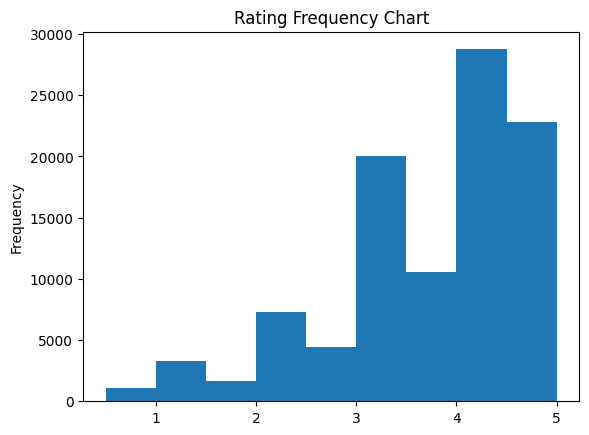

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")


# Read ratings_small.csv
df = pd. read_csv('ratings_small.csv')
df.drop(['timestamp'], axis=1, inplace=True)
df['movieId'] = df['movieId'].astype(int, errors='ignore')

print(f'Unique Values for Each Column: \n{df.apply(pd.Series.nunique)} \n')
print(f'There are {len(df)} ratings in total \n')
print("df.head(2)\n",df.head(2),"\n\n")

df_mean = df['rating'].mean()
print(f'Mean value is {df_mean:.2f}\n')
df['rating'].plot(kind='hist', bins=9, title='Rating Frequency Chart')



In [ ]:
#@title Read movies_metadata.csv
df_meta = pd.read_csv('movies_metadata.csv',
                      on_bad_lines='skip', low_memory=False)

df_meta.rename(columns={'id': 'tmdbId'}, inplace=True)
df_meta["tmdbId"] =pd.to_numeric(df_meta['tmdbId'], errors='coerce',downcast="integer")



In [ ]:
#@title Read movies_metadata.csv
df_links = pd.read_csv('links_small.csv',
                      on_bad_lines='skip', low_memory=False)
df_links = df_links[['movieId', 'tmdbId']]
df_links.drop_duplicates(subset=['tmdbId'], inplace=True)


In [ ]:
#@title Merge df, df_meta, df_links. (최초 1회 실행시에만 오류 안 남.)

# print(df_meta.head(2))
# print()
# print(df_links.head(2))

df_meta = pd.merge(df_links, df_meta, how='inner', on='tmdbId')
df_meta["movieId"] =pd.to_numeric(df_meta['movieId'], errors='coerce',downcast="integer")
df_meta.dropna(subset=["movieId"],inplace=True)

# print(df_meta.head(2),"\n\n")

df_meta = df_meta[['movieId',  'original_language', 'original_title', 'overview', 'revenue', 'runtime']]
df = pd.merge(df, df_meta, on="movieId",how="inner")
print(f'{df.info()}\n')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 99985 entries, 0 to 99984
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   userId             99985 non-null  int64  
 1   movieId            99985 non-null  int64  
 2   rating             99985 non-null  float64
 3   original_language  99985 non-null  object 
 4   original_title     99985 non-null  object 
 5   overview           99971 non-null  object 
 6   revenue            99850 non-null  float64
 7   runtime            99850 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 6.9+ MB
None



In [ ]:
print(df.head(5))

print(df['userId'].unique)

user_groupby = pd.Series(Counter(df['userId']))
print("\n\n",user_groupby)


movies_groupby = pd.Series(Counter(df['movieId']))
print("\n\n",movies_groupby)


   userId  movieId  rating original_language   original_title  \
0       1       31     2.5                en  Dangerous Minds   
1       7       31     3.0                en  Dangerous Minds   
2      31       31     4.0                en  Dangerous Minds   
3      32       31     4.0                en  Dangerous Minds   
4      36       31     3.0                en  Dangerous Minds   

                                            overview      revenue  runtime  
0  Former Marine Louanne Johnson lands a gig teac...  180000000.0     99.0  
1  Former Marine Louanne Johnson lands a gig teac...  180000000.0     99.0  
2  Former Marine Louanne Johnson lands a gig teac...  180000000.0     99.0  
3  Former Marine Louanne Johnson lands a gig teac...  180000000.0     99.0  
4  Former Marine Louanne Johnson lands a gig teac...  180000000.0     99.0  
<bound method Series.unique of 0          1
1          7
2         31
3         32
4         36
        ... 
99980    664
99981    664
99982    665

In [ ]:
#@title 언어가 'English'이고, 영화 평점을 많이 남긴 사람과 인기있는 영화만 남기고 전부 drop. (150번 초과 평가한 사람과 1000번 초과로 투표된 영화만)

df.drop(df[df['original_language'] != 'en'].index, inplace=True)

user_groupby = pd.Series(Counter(df['userId']))
freq_voters = user_groupby.loc[lambda x : x > 50]
print(f'In total, we will consider {freq_voters.size} voters as they voted for more than 150 movies')

movies_groupby = pd.Series(Counter(df['movieId']))
popular_movies = movies_groupby.loc[lambda x : x > 100]
print(f'In total, we will consider {popular_movies.size} movies as they are voted by  more than 1000 users')

freq_voters = np.array(freq_voters.index)
popular_movies = np.array(popular_movies.index)




df = df[df['userId'].isin(freq_voters)]
df = df[df['movieId'].isin(popular_movies)]
df.dropna(inplace=True)
print(f'{df.info()}\n')



In total, we will consider 404 voters as they voted for more than 150 movies
In total, we will consider 146 movies as they are voted by  more than 1000 users
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18941 entries, 911 to 62129
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   userId             18941 non-null  int64  
 1   movieId            18941 non-null  int64  
 2   rating             18941 non-null  float64
 3   original_language  18941 non-null  object 
 4   original_title     18941 non-null  object 
 5   overview           18941 non-null  object 
 6   revenue            18941 non-null  float64
 7   runtime            18941 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 1.3+ MB
None



In [ ]:
#@title 흠.. knn이랑 매트릭스를 같이써서 콜라보로 봐야할 것 가ㅌ기도 한데,, 일단,,,,,, 킵,,,

df_matrix =  df[['userId', 'original_title', 'rating']]
rating_matrix = df_matrix.pivot_table(index='original_title',  columns='userId', values='rating')
rating_matrix.info()
# print(f'{rating_matrix.info()}\n')

rating_matrix_filled = rating_matrix.apply(lambda row: row.fillna(0), axis=1)
# print(f'{rating_matrix_filled.info()}\n')



<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 2001: A Space Odyssey to X-Men
Columns: 404 entries, 2 to 671
dtypes: float64(404)
memory usage: 462.0+ KB


In [ ]:
#Training KNN model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=2)
knn.fit(rating_matrix_filled)



NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=2, n_neighbors=20)

In [ ]:
#@title 영화 이름과 knn,matrix를 넘겨주면 영화 이름에 맞춰서 추천함.

def movieRecommender(movie_name, knn, matrix):
  try:
    dist, idx = knn.kneighbors(matrix.loc[movie_name].values.reshape(1,-1),n_neighbors=20)
    print(f'For your selection of {movie_name}, I will recommend \n')
    for i in range(1, len(dist.flatten())):
      movie_name = matrix.index[idx.flatten()[i]]
      print(f'{i}- {movie_name}, distance is {dist.flatten()[i]:.3f}')
  except:
    print(f'The movie {movie_name} is not in our database. \n Please note that our database contains only popular movies up until mid 2017.')

In [ ]:
#@title 배트맨 영화와 거리가 가까운 것들부터 추천. 다크 나이트, 반지의 제왕 등 유사한 영화를 잘 추천하는 것을 확인할 수 있음.

movieRecommender('Batman Begins', knn, rating_matrix_filled)

For your selection of Batman Begins, I will recommend 

1- The Dark Knight, distance is 0.281
2- The Lord of the Rings: The Two Towers, distance is 0.335
3- The Lord of the Rings: The Return of the King, distance is 0.342
4- The Incredibles, distance is 0.370
5- Pirates of the Caribbean: The Curse of the Black Pearl, distance is 0.379
6- The Lord of the Rings: The Fellowship of the Ring, distance is 0.382
7- The Matrix, distance is 0.392
8- Kill Bill: Vol. 1, distance is 0.415
9- Fight Club, distance is 0.419
10- Ocean's Eleven, distance is 0.428
11- Kill Bill: Vol. 2, distance is 0.429
12- Spider-Man, distance is 0.437
13- Memento, distance is 0.450
14- X-Men, distance is 0.450
15- Monsters, Inc., distance is 0.452
16- Inception, distance is 0.462
17- Minority Report, distance is 0.465
18- Finding Nemo, distance is 0.476
19- Harry Potter and the Philosopher's Stone, distance is 0.480
